In [1]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import corner
import copy
import pickle
from astropy.io import ascii
from itertools import cycle
import math

import matplotlib.gridspec as gridspec

%matplotlib inline

# Plotting code

In [2]:
plt.style.use('ggplot')
%config InlineBackend.figure_format = 'retina'
mpl.rcParams['lines.linewidth'] = 2.5
mpl.rcParams['axes.facecolor']='white'
mpl.rcParams['axes.edgecolor']='k'
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['text.color'] = 'k'
#mpl.rcParams['xtick.major.width'] = 2
#mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.color']='k'
mpl.rcParams['ytick.color']='k'
mpl.rcParams['axes.labelcolor']='k'

mpl.rcParams['font.size']=12
mpl.rcParams['xtick.direction']='in'
mpl.rcParams['ytick.direction']='in'
mpl.rcParams['xtick.major.size'] = 5.5
mpl.rcParams['ytick.major.size'] = 5.5
mpl.rcParams['xtick.minor.size'] = 3.5
mpl.rcParams['ytick.minor.size'] = 3.5


def makeCmap(hexColour,zeroColour='#FFFFFF'):
    r0,g0,b0=mpl.colors.hex2color(zeroColour)
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r0, r0),
                   (1.0, r, r)),
         'green': ((0.0, g0, g0),
                   (1.0, g, g)),
         'blue':  ((0.0, b0, b0),
                   (1.0, b, b))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makeGradient(hexColour):
    r,g,b=mpl.colors.hex2color(hexColour)
    cdict = {'red':   ((0.0, r, r),
                   (1.0, r, r)),
         'green': ((0.0, g, g),
                   (1.0, g, g)),
         'blue':  ((0.0, b, b),
                   (1.0, b, b)),
         'alpha':  ((0.0, 0.0, 0.0),
                   (1.0, 1.0, 1.0))
        }
    cmap = mpl.colors.LinearSegmentedColormap(hexColour,cdict)
    return cmap


def makePlotColours(mappableList,coloursList):
    """
    mappableArray = a list of discrete values, each corresponding to a unique color (zero-indexed)
    coloursList = list of desired colors. Ideally should be at least as many colours as there are unique
                  entries in mappableArray.
    """
    
    zidx = []
    uniqueMappableList = np.unique(mappableList)
    for j in range(len(mappableList)):
        for i,entry in enumerate(uniqueMappableList):
            if mappableList[j] == entry:
                zidx.append(i)
    
    zidx = np.array((zidx))
    uniqueVals = len(np.unique(zidx))
    
    cidx = 0
    colourMaps = []
    cycledColours = []
    for c in cycle(coloursList):
        colourMaps.append(makeGradient(c))
        cycledColours.append(c)
        cidx+=1
        if cidx >= uniqueVals: 
            break
    
    blankCmap=makeGradient('#FFFFFF')
    colours = blankCmap(0.999*np.ones_like(zidx))

    for j in range(0,uniqueVals):
        colours[zidx==j] = colourMaps[j](0.999*np.ones_like(np.arange(0,len(zidx))[zidx==j]))

    return colourMaps,colours,cycledColours,list(uniqueMappableList)

# Understanding the cost function --- plotting terms, etc

## J [to be minimized] =  H(q,p) [cross-entropy term] - H(z) [prevents trivial solutions]

In [3]:
def crossEntropy(q, p):
    q[q==0.] = 1.e-15
    p[p==0.] = 1.e-15
    return -np.sum(q*np.log(p))

## One training example. How do the components of J depend on (1) agreement between classifiers q and p and (2) confidence of classifiers q and p?

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


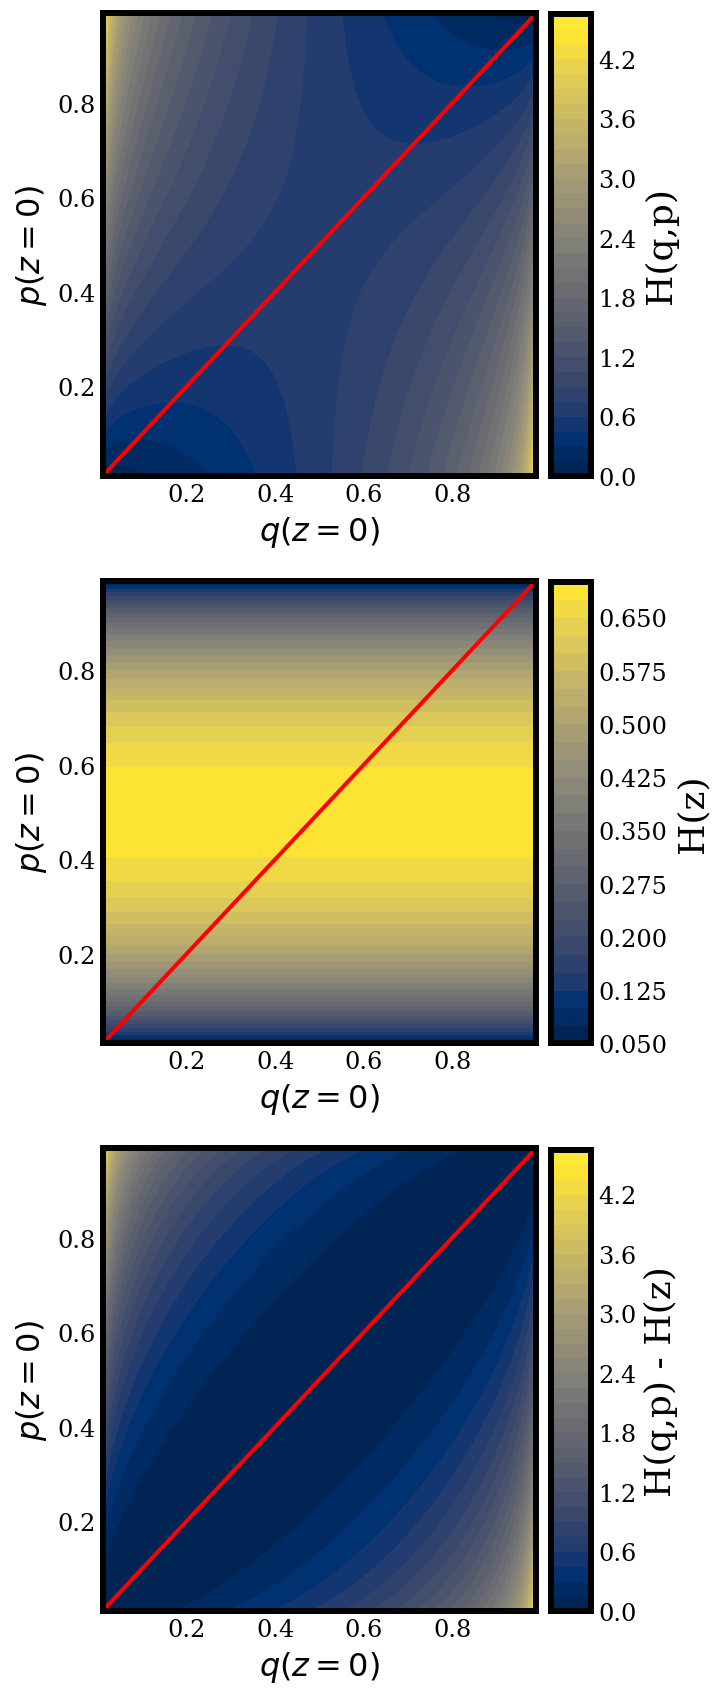

In [6]:
q0 = np.linspace(0.01,0.99,100)

ces_em = np.zeros((len(q0),len(q0)))
ces_Hz_em = np.zeros((len(q0),len(q0)))

ces_zep = np.zeros((len(q0),len(q0)))
ces_Hz_zep = np.zeros((len(q0),len(q0)))

Hzs = np.zeros((len(q0),len(q0)))

for i in range(len(q0)):
    for j in range(len(q0)):
        qarr = np.array((q0[i],1. - q0[i]))
        parr = np.array((q0[j],1. - q0[j]))
        
        ces_em[i,j] = crossEntropy(qarr,parr)
        ces_zep[i,j] = -q0[i]*np.log(q0[j]) - (1. - q0[i])*np.log(1. - q0[j])
        
        Hzs[i,j] = ( -q0[i]*np.log(q0[i]) - (1.-q0[i])*np.log(1.-q0[i]))
        
        ces_Hz_em[i,j] = crossEntropy(qarr,parr) - ( -q0[i]*np.log(q0[i]) - (1.-q0[i])*np.log(1.-q0[i]))
        ces_Hz_zep[i,j] = -q0[i]*np.log(q0[j]/q0[i]) - (1. - q0[i])*np.log((1.-q0[j])/(1.-q0[i]))
        
fig = plt.figure(figsize=(4,12))
gs = gridspec.GridSpec(3,1)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])

h0 = ax0.contourf(q0,q0,ces_em,30,vmin=0.,vmax=4.5,cmap='cividis')
h1 = ax1.contourf(q0,q0,Hzs,30,cmap='cividis')
h2 = ax2.contourf(q0,q0,ces_Hz_zep,30,vmin=0.,vmax=4.5,cmap='cividis')

cax0 = fig.add_axes([0.98, 0.7175, 0.07, 0.267])
cax1 = fig.add_axes([0.98, 0.389, 0.07, 0.267])
cax2 = fig.add_axes([0.98, 0.0605, 0.07, 0.267])

cb0 = fig.colorbar(h0, cax=cax0, orientation='vertical')
cb1 = fig.colorbar(h1, cax=cax1, orientation='vertical')
cb2 = fig.colorbar(h2, cax=cax2, orientation='vertical')

cblabels = ['H(q,p)','H(z)','H(q,p) - H(z)']
for i,cb in enumerate([cb0,cb1,cb2]):
    cb.set_label(cblabels[i],fontsize=18)
    
for ax in [ax0,ax1,ax2]:
    ax.plot(q0,q0,'r-',lw=2)
    ax.set_xlabel(r"$q(z=0)$",fontsize=16)
    ax.set_ylabel(r"$p(z=0)$",fontsize=16)
#plt.xlim(-0.1,1.1)
#plt.ylim(-0.1,1.1)
#plt.show()
plt.tight_layout()
plt.savefig("./costFunction_1trainingexample.pdf",fmt="pdf",bbox_inches="tight")

## Many identical training examples. How do the components of J depend on (1) agreement between classifiers q and p and (2) confidence of classifiers q and p?

### Answer: it's the same as above, because of the 1/N weighting on the cross-entropy term .

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


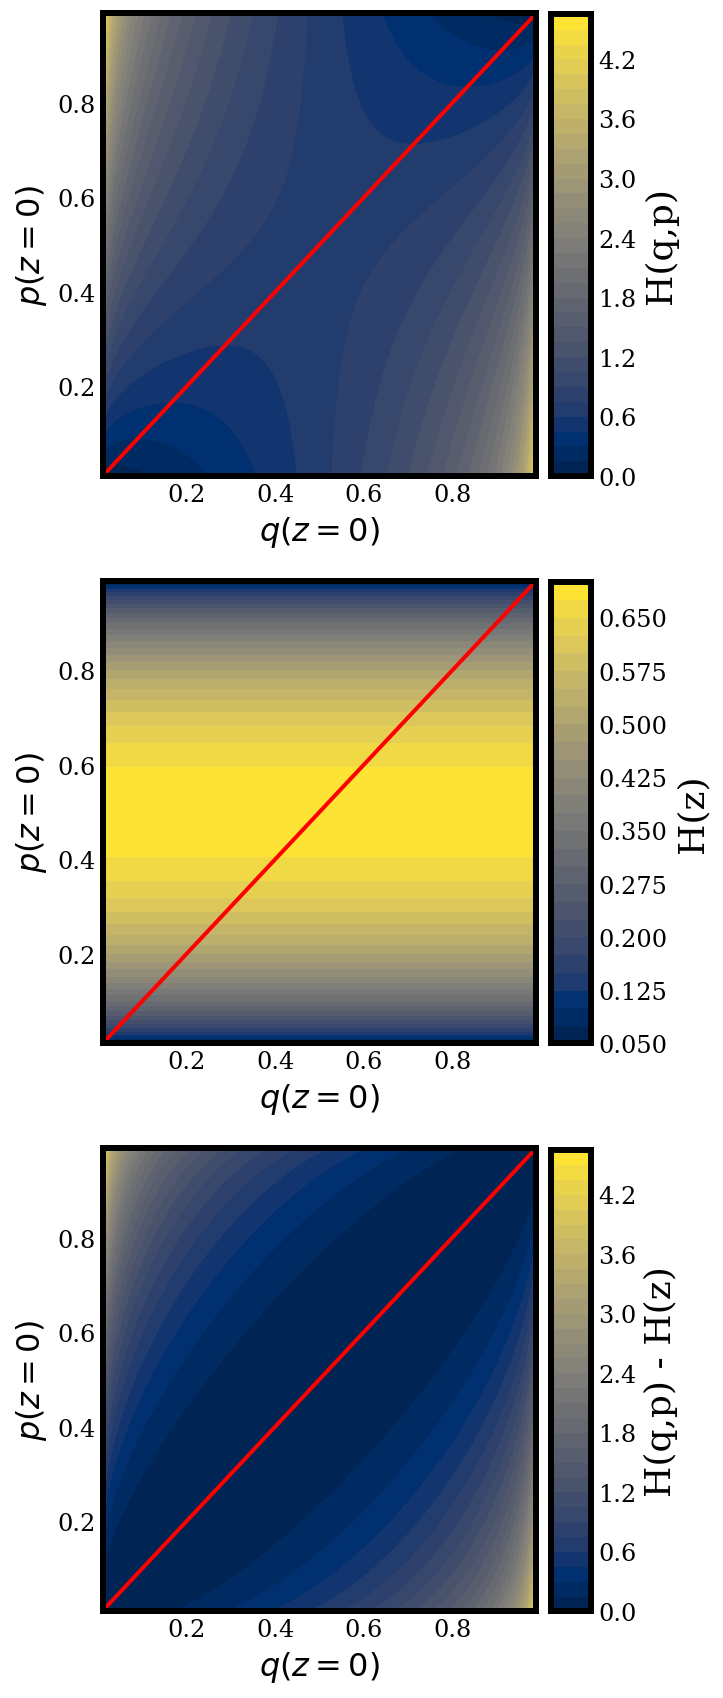

In [7]:
nTraining = 10

q0 = np.linspace(0.01,0.99,100)

ces_em = np.zeros((len(q0),len(q0)))
ces_Hz_em = np.zeros((len(q0),len(q0)))

Hzs = np.zeros((len(q0),len(q0)))

for k in range(nTraining):
    for i in range(len(q0)):
        for j in range(len(q0)):
            qarr = np.array((q0[i],1. - q0[i]))
            parr = np.array((q0[j],1. - q0[j]))

            ces_em[i,j] += (1./nTraining)*crossEntropy(qarr,parr)

for i in range(len(q0)):
    for j in range(len(q0)):
        Hzs[i,j] = ( -q0[i]*np.log(q0[i]) - (1.-q0[i])*np.log(1.-q0[i]))

ces_Hz_em = ces_em - Hzs

fig = plt.figure(figsize=(4,12))
gs = gridspec.GridSpec(3,1)
ax0 = fig.add_subplot(gs[0,:])
ax1 = fig.add_subplot(gs[1,:])
ax2 = fig.add_subplot(gs[2,:])

h0 = ax0.contourf(q0,q0,ces_em,30,vmin=0.,cmap='cividis')
h1 = ax1.contourf(q0,q0,Hzs,30,cmap='cividis')
h2 = ax2.contourf(q0,q0,ces_Hz_em,30,vmin=0.,cmap='cividis')

cax0 = fig.add_axes([0.98, 0.7175, 0.07, 0.267])
cax1 = fig.add_axes([0.98, 0.389, 0.07, 0.267])
cax2 = fig.add_axes([0.98, 0.0605, 0.07, 0.267])

cb0 = fig.colorbar(h0, cax=cax0, orientation='vertical')
cb1 = fig.colorbar(h1, cax=cax1, orientation='vertical')
cb2 = fig.colorbar(h2, cax=cax2, orientation='vertical')

cblabels = ['H(q,p)','H(z)','H(q,p) - H(z)']
for i,cb in enumerate([cb0,cb1,cb2]):
    cb.set_label(cblabels[i],fontsize=18)
    
for ax in [ax0,ax1,ax2]:
    ax.plot(q0,q0,'r-',lw=2)
    ax.set_xlabel(r"$q(z=0)$",fontsize=16)
    ax.set_ylabel(r"$p(z=0)$",fontsize=16)
#plt.xlim(-0.1,1.1)
#plt.ylim(-0.1,1.1)
#plt.show()
plt.tight_layout()
plt.savefig("./costFunction_manyidenticaltrainingexamples.pdf",fmt="pdf",bbox_inches="tight")

## Many *different* training examples. How do the components of J depend on (1) agreement between classifiers q and p and (2) confidence of classifiers q and p?

### Answer: It likes when the classifiers agree confidently, but hates when they disagree confidently.

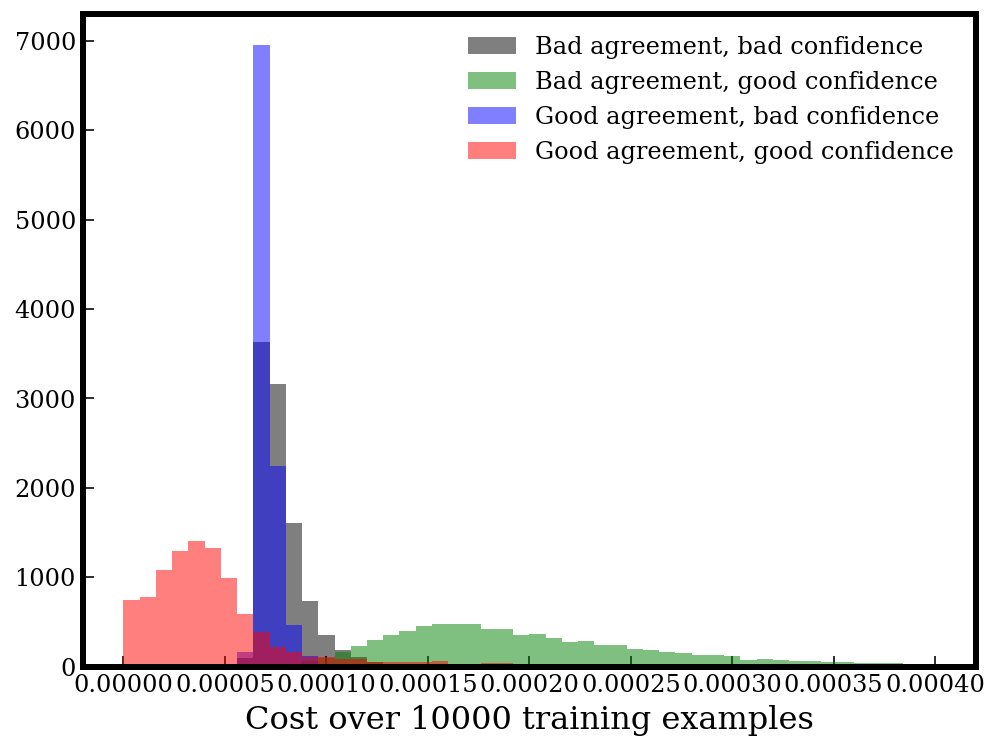

In [6]:
nTraining = 10000
# Bad agreement, bad confidence
q0_bb = np.concatenate((np.random.normal(loc=0.6,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.4,scale=0.1,size=int(nTraining/2))))
p0_bb = np.concatenate((np.random.normal(loc=0.4,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.6,scale=0.1,size=int(nTraining/2))))

# Good agreement, bad confidence
q0_gb = np.random.normal(loc=0.5,scale=0.1,size=nTraining)
p0_gb = np.random.normal(loc=0.5,scale=0.1,size=nTraining)

# Bad agreement, good confidence
q0_bg = np.concatenate((np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2))))
p0_bg = np.concatenate((np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2)), np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2))))

# Good agreement, good confidence
q0_gg = np.concatenate((np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2)),np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2))))
p0_gg = np.concatenate((np.random.normal(loc=0.9,scale=0.1,size=int(nTraining/2)),np.random.normal(loc=0.1,scale=0.1,size=int(nTraining/2))))

qlist = [q0_bb, q0_gb, q0_bg, q0_gg]
plist = [p0_bb, p0_gb, p0_bg, p0_gg]

J_bb = np.zeros_like(q0_bb)
J_gb = np.zeros_like(q0_gb)
J_bg = np.zeros_like(q0_bg)
J_gg = np.zeros_like(q0_gg)
Jlist = [J_bb, J_gb, J_bg, J_gg]

for k in range(4):
    qs = qlist[k]
    ps = plist[k]
    Js = Jlist[k]
    
    qs[qs < 0.0001] = 0.0001
    qs[qs > 0.9999] = 0.9999
    
    ps[ps < 0.0001] = 0.0001
    ps[ps > 0.9999] = 0.9999
    
    
    CE = 0.
    
    for i in range(len(qs)):
        qarr = np.array((qs[i],1.-qs[i]))
        parr = np.array((ps[i],1.-ps[i]))
        
        CE = (1./nTraining)*crossEntropy(qarr,parr)
        Js[i] = CE
    
    
    #Hz calculation
    q_class0 = len(np.arange(len(qs))[qs < 0.5])/len(qs)
    if q_class0 < 0.00001:
        q_class0 = 0.00001
        
    if q_class0 > 0.99999:
        q_class0 = 0.99999
    q_class1 = 1. - q_class0
    
    Hz = -q_class0*np.log(q_class0) - q_class1*np.log(q_class1)
    
    Js = Js - Hz
    
fig = plt.figure(figsize=(8,6))
plt.hist(J_bb,color='k',bins=50,alpha=0.5,range=(0.,0.0004),label='Bad agreement, bad confidence')
plt.hist(J_bg,color='g',bins=50,alpha=0.5,range=(0.,0.0004),label='Bad agreement, good confidence')
plt.hist(J_gb,color='b',bins=50,alpha=0.5,range=(0.,0.0004),label='Good agreement, bad confidence')
plt.hist(J_gg,color='r',bins=50,alpha=0.5,range=(0.,0.0004),label='Good agreement, good confidence')
plt.legend(loc='upper right',frameon=False)
plt.xlabel("Cost over 10000 training examples",fontsize=16)
#plt.show()
plt.savefig("./costFunction_manydifferenttrainingexamples.pdf",fmt="pdf",bbox_inches="tight")

# Entropy term only, 2 classes

/Users/Emily/anaconda3/lib/python3.7/site-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in log
  from ipykernel import kernelapp as app


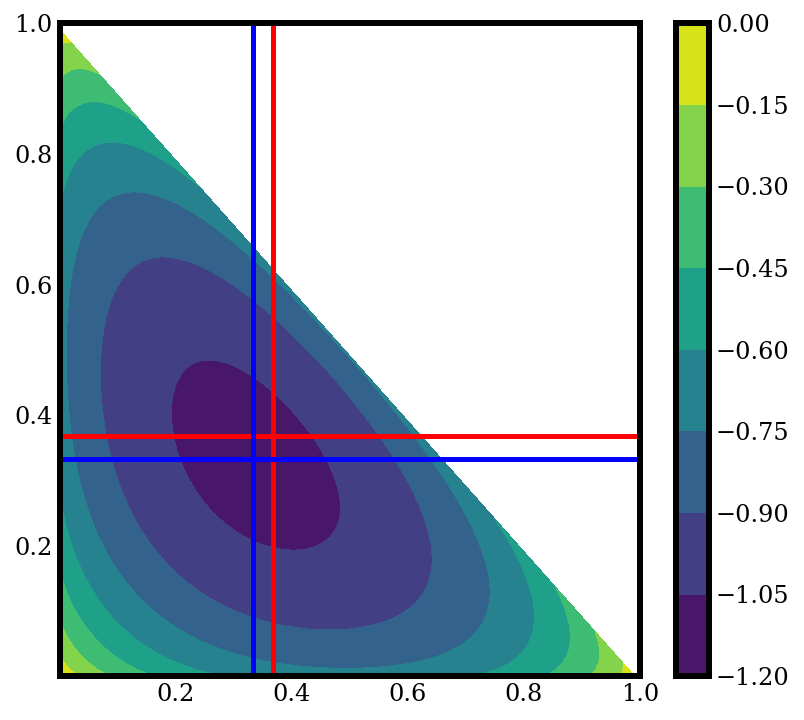

-1.087435607015455
-1.0986122886681096


In [7]:
def Hz(a,b):
    return a*np.log(a) + b*np.log(b) + (1-a-b)*np.log(1-a-b)


a = np.linspace(0.001,1.,100)
b = np.linspace(0.001,1.,100)


hzs = np.zeros((len(a),len(a)))

for i in range(len(a)):
    for j in range(len(b)):
        hzs[i,j] = Hz(a[i],b[j])
        
fig = plt.figure(figsize=(6.5,6))
plt.contourf(a,b,hzs)
plt.colorbar()
plt.axhline(1./np.e,color='r')
plt.axvline(1./np.e,color='r')
plt.axhline(1./3.,color='b')
plt.axvline(1./3.,color='b')
plt.show()

print(Hz(1./np.e,1./np.e))
print(Hz(1./3.,1./3.))

# Try to reproduce what's going on in the training code

In [8]:
def softmax(x,b):
    return np.exp(b*x)/np.sum(np.exp(b*x))

def calculateEntropy(probs):
    x = np.multiply(probs,np.log(probs))
    entro = -1. * np.sum(x)
    return entro

In [9]:
def loss(targetProbs, contextProbs):
    """
    assuming targetProbs is the output of a softmax
        
    contextProbs is ln(the output of a softmax)
        
    """
        
    pZ_Y = targetProbs

    pZ = np.mean(pZ_Y,axis=0)
    hZ = calculateEntropy(pZ)
        
    x = np.multiply(pZ_Y, contextProbs)
    hZ_X_ub = -1.0 * np.mean(np.sum(x,axis=1)) # scalar
        
    print("term 1 is {0}".format(hZ_X_ub))
    loss = hZ_X_ub - hZ
    print("term 2 is {0}".format(hZ))

    bits = -1.*loss * math.log(math.e,2)
    return loss, bits

def confidentLoss(targetProbs, contextProbs, softmax_scale=1.):
    """
    assuming targetProbs is the output of a softmax
        
    contextProbs is ln(the output of a softmax)
        
    """
    pZ_Y = targetProbs

    pZ = np.mean(pZ_Y,axis=0)
    hZ = calculateEntropy(pZ)
    
    
    contextProbs_temp = 0.00001*np.ones_like(contextProbs)
        
    for i in range(0,len(contextProbs)):
        bestClass_context = np.argmax(np.exp(contextProbs[i]))
        contextProbs_temp[i][bestClass_context] = 1.0 - 0.00002
    
    contextProbs_logsoftmax = np.log(contextProbs_temp)
        
    x = np.multiply(pZ_Y, contextProbs)
    hZ_X_ub = -1.0 * np.mean(np.sum(x,axis=1)) # scalar

    loss = hZ_X_ub - hZ
    
    print("term 1 is {0}".format(hZ_X_ub))
    print("term 2 is {0}".format(hZ))

    bits = -1.*loss * math.log(math.e,2)
    return loss, bits

In [10]:
experimentClass = "oneGrammar_distinctRp"
experimentName = "allFeatures_uniformP_wide"
n_planet_features = 2
n_stellar_features = 3
n_features = n_planet_features + n_stellar_features

-1.067599778783649
1.540220906505325


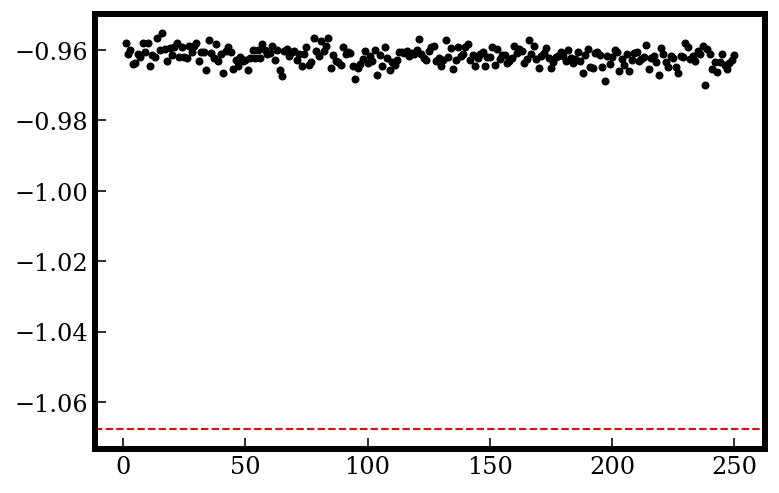

In [11]:
results = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_classprobs_softmax.npy".format(experimentClass,experimentName))
results_fromContext = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_classprobs_fromcontext_logsoftmax.npy".format(experimentClass,experimentName))

idxs = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_idxs.npy".format(experimentClass,experimentName))
losses = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_losses.npy".format(experimentClass,experimentName))

optimalLoss = float(np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_optimalLoss.npy".format(experimentClass,experimentName)))
print(optimalLoss)
bits = -1*optimalLoss*math.log(math.e,2)
print(bits)
plt.plot(losses[:,0],losses[:,1],'k.')
plt.axhline(y=optimalLoss,color='r',ls="--",lw=1)
plt.show()

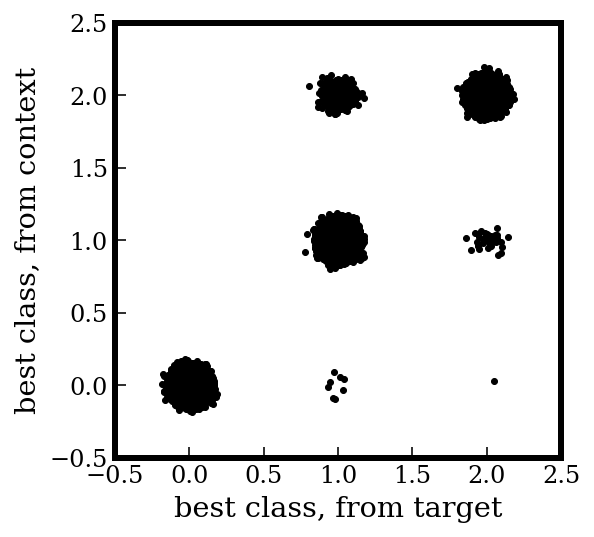

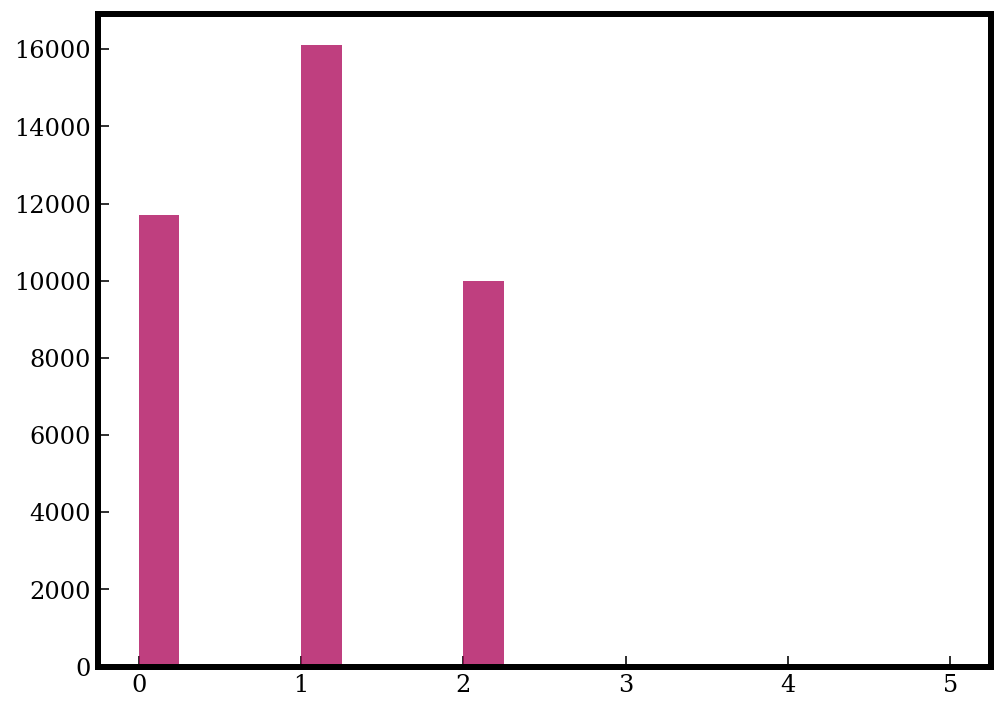

In [12]:
with open("simulatedPlanets/{0}/fake_grammaticalSystems_{1}.txt".format(experimentClass,experimentName), "rb") as picklefile:
    systems = pickle.load(picklefile)

data = np.zeros((1,n_features))

for i in range(len(systems)):
    sys = systems[i]
    for j in range(len(sys)):
        data = np.vstack((data,np.array(sys[j])))
        
data = data[1:][idxs]
#print(np.shape(data))

bestClass = np.argmax(results,axis=1)
bestClass_fromContext = np.argmax(results_fromContext,axis=1)
#print(bestClass)
#print(np.shape(bestClass))

fig = plt.figure(figsize=(4,4))
plt.scatter(bestClass+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass)),bestClass_fromContext+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass_fromContext)),color='k',marker='.',alpha=1)
plt.xlabel("best class, from target")
plt.ylabel("best class, from context")
plt.xlim(-.5,2.5)
plt.ylim(-.5,2.5)
plt.show()


trueClass = np.load("./simulatedPlanets/{0}/fake_grammaticalSystems_{1}_truths.npy".format(experimentClass,experimentName))
trueClass = trueClass[idxs]
#print(np.shape(trueClass))
#print(trueClass)

#note ---the bars don't line up in this histogram because the class labels are out of order!
fig = plt.figure(figsize=(8,6))
plt.hist(bestClass,bins=20,range=(0,5),color='b',alpha=0.5)
plt.hist(trueClass,bins=20,range=(0,5),color='r',alpha=0.5)
plt.show()

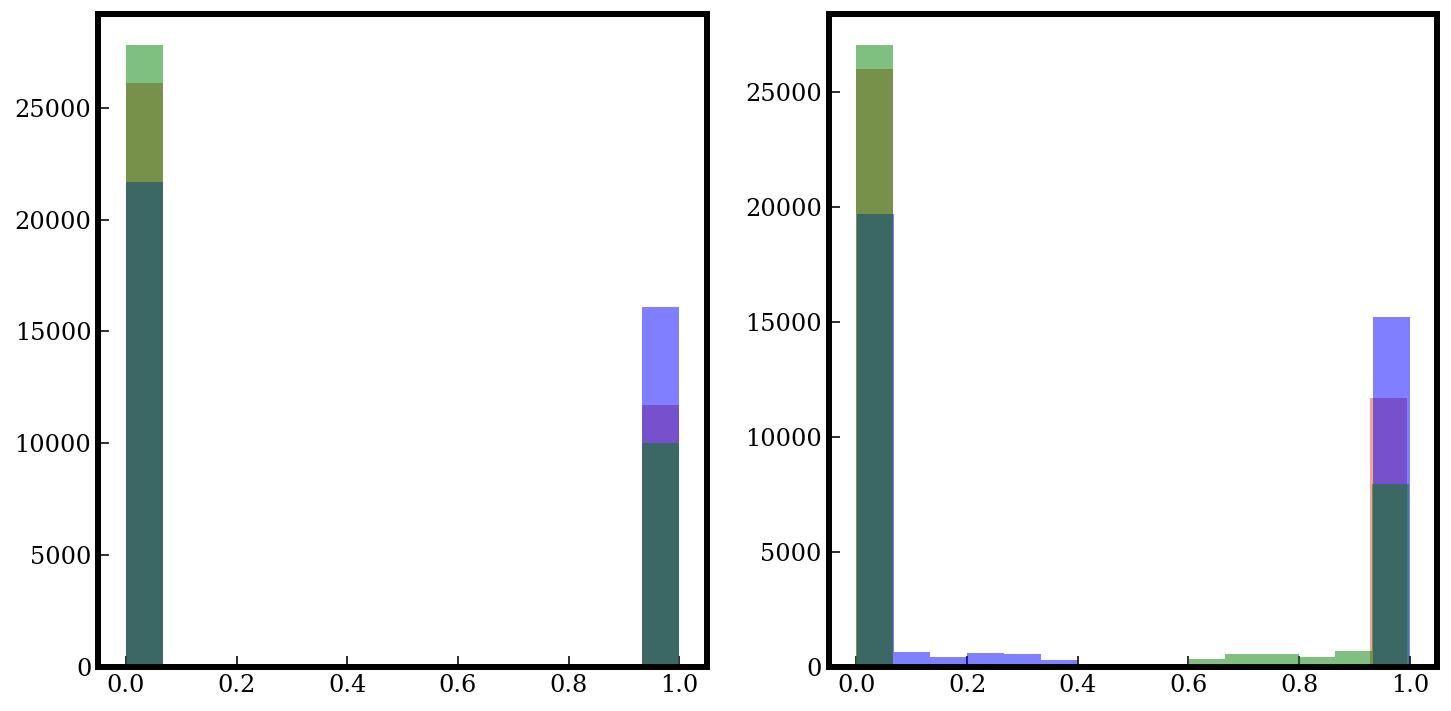

In [13]:
fig,axes = plt.subplots(1,2,figsize=(12,6))
axes[0].hist(results[:,0],bins=15,alpha=0.5)
axes[0].hist(results[:,1],bins=15,color='b',alpha=0.5)
axes[0].hist(results[:,2],bins=15,color='g',alpha=0.5)
axes[1].hist(np.exp(results_fromContext[:,0]),bins=15,alpha=0.5)
axes[1].hist(np.exp(results_fromContext[:,1]),bins=15,color='b',alpha=0.5)
axes[1].hist(np.exp(results_fromContext[:,2]),bins=15,color='g',alpha=0.5)
plt.show()

In [15]:
# ensuring that we're near the theoretical optimum for J = H(p,p) - H(p)
l,b = loss(targetProbs=results, contextProbs=np.log(results+0.0001))
print(l,b)

l,b = loss(targetProbs=np.exp(results_fromContext), contextProbs=results_fromContext)
print(l,b)

l,b = confidentLoss(targetProbs=np.exp(results_fromContext), contextProbs=results_fromContext)
print(l,b)


term 1 is -9.999500033329658e-05
term 2 is 1.0782711705717423
-1.0783711655720756 1.5557607328084846
term 1 is 0.09742364689157873
term 2 is 1.078908091657853
-0.9814844447662743 1.4159827411739616
term 1 is 0.09742364689157873
term 2 is 1.078908091657853
-0.9814844447662743 1.4159827411739616


In [16]:
# What we actually get:
l,b = loss(targetProbs=results, contextProbs=results_fromContext)
print(l,b)

l,b = confidentLoss(targetProbs=results, contextProbs=results_fromContext)
print(l,b)

term 1 is 0.05155185988686268
term 2 is 1.0782711705717423
-1.0267193106848795 1.4812428579100105
term 1 is 0.05155185988686268
term 2 is 1.0782711705717423
-1.0267193106848795 1.4812428579100105


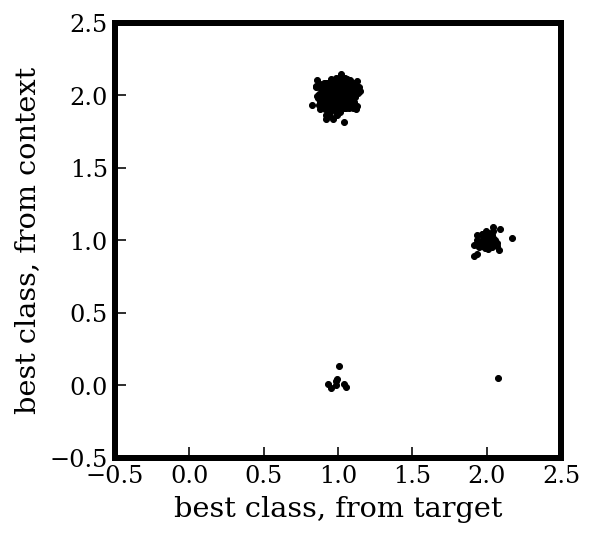

In [17]:
# figure out nWrong, nDisagree, and then see if calculating the loss function on 
#(perfectly confident results with nWrong, wrong)
# matches what we get

nTarget_wrong = len(np.arange(len(bestClass))[bestClass != trueClass])
nContext_wrong = len(np.arange(len(bestClass))[bestClass_fromContext != trueClass])
nDisagree = len(np.arange(len(bestClass))[bestClass != bestClass_fromContext])


# plot only mis-classifications

fig = plt.figure(figsize=(4,4))
plt.scatter(bestClass[bestClass_fromContext != trueClass]+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass[bestClass_fromContext != trueClass])),
            bestClass_fromContext[bestClass_fromContext != trueClass]+np.random.normal(loc=0.0,scale=0.05,size=len(bestClass_fromContext[bestClass_fromContext != trueClass])),color='k',marker='.',alpha=1)
plt.xlabel("best class, from target")
plt.ylabel("best class, from context")
plt.xlim(-.5,2.5)
plt.ylim(-.5,2.5)
plt.show()


In [18]:
print(nTarget_wrong, nContext_wrong, nDisagree)

0 677 677


In [19]:
trueClass_probs = np.zeros_like(results)
trueClass_probs_randomized = np.zeros_like(results)
for i in range(0,len(trueClass)):
    trueClass_probs[i][int(trueClass[i])] = 1.

rand_idxs = np.random.choice(np.arange(len(trueClass)), size=nDisagree)
trueClass_randomized = copy.deepcopy(trueClass)
trueClass_randomized[rand_idxs] = (trueClass_randomized[rand_idxs] + 1) % 3

for i in range(0,len(trueClass_randomized)):
    trueClass_probs_randomized[i][int(trueClass_randomized[i])] = 1.

l, b = confidentLoss(trueClass_probs,np.log(trueClass_probs+0.0001))
print(l,b)
l, b = confidentLoss(trueClass_probs,np.log(trueClass_probs_randomized+0.0001))
print(l,b)

trueClass_probs_randomized_notConfident = copy.deepcopy(trueClass_probs_randomized)
for i in range(len(trueClass_probs_randomized_notConfident)):
    yesmask = trueClass_probs_randomized_notConfident[i] > 0.5
    trueClass_probs_randomized_notConfident[i][yesmask] = trueClass_probs_randomized_notConfident[i][yesmask] - 0.2
    trueClass_probs_randomized_notConfident[i][~yesmask] = trueClass_probs_randomized_notConfident[i][~yesmask] + 0.1
    # ^^^ even those crazy values are not enough to make this match the network-calculated cost!!! something is wrong
l, b = confidentLoss(trueClass_probs,np.log(trueClass_probs_randomized_notConfident+0.0001))
print(l,b)


term 1 is -9.999500033329728e-05
term 2 is 1.0782711705717423
-1.0783711655720756 1.5557607328084846
term 1 is 0.1631667998742405
term 2 is 1.0782711705717423
-0.9151043706975017 1.3202165375011015
term 1 is 0.2598638090789224
term 2 is 1.0782711705717423
-0.8184073614928198 1.1807122418527123


In [20]:
# theoretical optimum
l,b = loss(targetProbs=trueClass_probs,contextProbs=np.log(trueClass_probs+0.0001))
print(l,b)
l,b = confidentLoss(targetProbs=trueClass_probs, contextProbs=np.log(trueClass_probs+0.0001))
print(l,b)

term 1 is -9.999500033329728e-05
term 2 is 1.0782711705717423
-1.0783711655720756 1.5557607328084846
term 1 is -9.999500033329728e-05
term 2 is 1.0782711705717423
-1.0783711655720756 1.5557607328084846
